In [71]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, auc, f1_score, balanced_accuracy_score, f1_score, matthews_corrcoef, precision_score, recall_score, roc_auc_score

In [2]:
with open('../3_go_dict/classes.pkl', 'rb') as f:
    names = pickle.load(f)

In [3]:
with open("go_order","rb") as f:
    ordered = pickle.load(f)

with open("go_imbal_order","rb") as f:
    ordered_imbal = pickle.load(f)

In [4]:
dfTest = pd.read_pickle("Testset.pkl")

In [5]:
dfFinal, df = train_test_split(dfTest, random_state = 55, test_size = 0.35)

# Create Column with predictions and probabilities

### for final evaluation set as well as test validation set

In [6]:
predictions = []
predictionProba = []
for i in names:
    model = joblib.load("CalcsBalanced/Models/Estimator_"+i+".pkl")
    predictions.append(model.predict(list(df["SeqVec"])))
    predictionProba.append(model.predict_proba(list(df["SeqVec"])))

In [7]:
for i in range(len(predictions)):
    df["preds_"+str(i)] = predictions[i]

/home/jonas/anaconda3/envs/pbl/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
predictionProba = np.array(predictionProba).T[1].T

In [9]:
for i in range(len(predictionProba)):
    df["predProba_"+str(i)] = predictionProba[i]

/home/jonas/anaconda3/envs/pbl/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
predictions = []
predictionProba = []
for i in names:
    model = joblib.load("CalcsBalanced/Models/Estimator_"+i+".pkl")
    predictions.append(model.predict(list(dfFinal["SeqVec"])))
    predictionProba.append(model.predict_proba(list(dfFinal["SeqVec"])))

In [11]:
for i in range(len(predictions)):
    dfFinal["preds_"+str(i)] = predictions[i]

/home/jonas/anaconda3/envs/pbl/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
predictionProba = np.array(predictionProba).T[1].T

In [13]:
for i in range(len(predictionProba)):
    dfFinal["predProba_"+str(i)] = predictionProba[i]

/home/jonas/anaconda3/envs/pbl/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Path multiplication algorithm

In [14]:
with open("../3_go_dict/hierarchy.pkl", "rb") as f:
    go = pickle.load(f)

In [15]:
def getDepth(term):
    if term == "GO:0003674":
        return 0
    else:
        return 1+max(getDepth(i) for i in go[term]["is_a"])

In [16]:
classesDepth = {}
for i in names:
    classesDepth[i] = getDepth(i)

In [17]:
classSorted = [k for k,v in sorted(classesDepth.items(), key=lambda item: item[1])]

In [18]:
dfMod = pd.DataFrame()
for i in range(len(df)):
    series = df.iloc[i].copy()
    for j in classSorted:
        if classesDepth[j] == 1:
            series["modPredProba_"+str(names[j])] = series["predProba_"+str(names[j])]
        else:
            # averaging the parents probabilities
            proba = np.average([series["modPredProba_"+str(names[k])] for k in go[j]["is_a"]])
            series["modPredProba_"+str(names[j])] = series["predProba_"+str(names[j])] * proba
        
    if i == 0:
        dfMod = pd.DataFrame([series])
    else:
        dfMod = dfMod.append(series)

In [19]:
dfModFinal = pd.DataFrame()
for i in range(len(dfFinal)):
    series = dfFinal.iloc[i].copy()
    for j in classSorted:
        if classesDepth[j] == 1:
            series["modPredProba_"+str(names[j])] = series["predProba_"+str(names[j])]
        else:
            # averaging the parents probabilities
            proba = np.average([series["modPredProba_"+str(names[k])] for k in go[j]["is_a"]])
            series["modPredProba_"+str(names[j])] = series["predProba_"+str(names[j])] * proba
        
    if i == 0:
        dfModFinal = pd.DataFrame([series])
    else:
        dfModFinal = dfModFinal.append(series)

# Results with Path probability

In [20]:
probs = {}
name = list(names)

for i in range(38):    
    y_test = dfMod["preds"].apply(lambda x: 1 if x[i]==1 else 0)            
    y_predProba = dfMod["modPredProba_"+str(i)]
    y_pred = dfMod["preds_"+str(i)]

    #### TP

    tp = dfMod[y_test==y_pred][y_pred == 1]["modPredProba_"+str(i)]

    #### TN

    tn = dfMod[y_test==y_pred][y_pred == 0]["modPredProba_"+str(i)]

    #### FP

    fp = dfMod[y_test!=y_pred][y_pred == 1]["modPredProba_"+str(i)]

    #### FN

    fn = dfMod[y_test!=y_pred][y_pred == 0]["modPredProba_"+str(i)]

    
    probs[name[i]] = {"tp": np.average(tp), "tp_dev":np.std(tp), "tn": np.average(tn), "tn_dev":np.std(tn), "fp": np.average(fp), "fp_dev":np.std(fp), "fn": np.average(fn), "fn_dev":np.std(fn)}


/home/jonas/anaconda3/envs/pbl/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/jonas/anaconda3/envs/pbl/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/home/jonas/anaconda3/envs/pbl/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/jonas/anaconda3/envs/pbl/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [21]:
for i in probs:
    current = probs[i]
    if current["tp"] - current["tp_dev"] > current["fp"] + current["fp_dev"]:
        print(i+" is statistically significant")
    elif current["tp"] < current["fp"]:
        print(i+" terrible result")
    elif current["tp"] > current["fp"] + current["fp_dev"]:
        print(i+" at least a little")
    else:
        print(i+" Overlap of: "+str((current["tp"] - current["tp_dev"]) - (current["fp"] + current["fp_dev"])))

GO:0000976 at least a little
GO:0000977 at least a little
GO:0000978 at least a little
GO:0000981 at least a little
GO:0000987 at least a little
GO:0001012 at least a little
GO:0001067 at least a little
GO:0001216 is statistically significant
GO:0001228 at least a little
GO:0003676 at least a little
GO:0003677 at least a little
GO:0003690 at least a little
GO:0003700 at least a little
GO:0003824 Overlap of: -0.15486815486292826
GO:0004672 is statistically significant
GO:0004674 is statistically significant
GO:0005488 Overlap of: -0.13666736671010127
GO:0005515 Overlap of: -0.16473072584883097
GO:0008270 at least a little
GO:0016301 is statistically significant
GO:0016740 at least a little
GO:0016772 at least a little
GO:0016773 is statistically significant
GO:0042802 Overlap of: -0.10514800793812086
GO:0042803 terrible result
GO:0043167 at least a little
GO:0043169 at least a little
GO:0043565 at least a little
GO:0044212 at least a little
GO:0046872 at least a little
GO:0046914 Overla

# Prediction with path probability

### Test Validation Set

In [22]:
precision = []
recall = []
bacc = []
matthew = []
f1 = []

precision_dic = {}
recall_dic = {}
bacc_dic = {}
matthew_dic = {}
f1_dic = {}


for i in range(38):
    y_test = dfMod["preds"].apply(lambda x: 1 if x[i]==1 else 0)            

    y_pred = [1  if j > (probs[name[i]]["tp"]-probs[name[i]]["tp_dev"]) else 0 for j in dfMod["modPredProba_"+str(i)]]

    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    bacc.append(balanced_accuracy_score(y_test, y_pred))
    matthew.append(matthews_corrcoef(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    
    precision_dic[name[i]] = precision[-1]
    recall_dic[name[i]] = recall[-1]
    bacc_dic[name[i]] = bacc[-1]
    f1_dic[name[i]] = f1[-1]
    matthew_dic[name[i]] = matthew[-1]

/home/jonas/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


### Final Test Set

In [23]:
precision = []
recall = []
bacc = []
matthew = []
f1 = []

f1_dic = {}
bacc_dic = {}
prec_dic = {}
recall_dic = {}
mcc_dic = {}

for i in range(38):
    y_test = dfModFinal["preds"].apply(lambda x: 1 if x[i]==1 else 0)            
    probas = probs[name[i]]["tp"]-probs[name[i]]["tp_dev"]
    y_pred = [1  if j > probas else 0 for j in dfModFinal["modPredProba_"+str(i)]]

    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    bacc.append(balanced_accuracy_score(y_test, y_pred))
    matthew.append(matthews_corrcoef(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    
    f1_dic[name[i]] = f1[-1]
    bacc_dic[name[i]] = bacc[-1]
    prec_dic[name[i]] = precision[-1]
    recall_dic[name[i]] = recall[-1]
    mcc_dic[name[i]] = matthew[-1]

# get vector of final predictions

In [24]:
for i in range(38):
    probas = probs[name[i]]["tp"]-probs[name[i]]["tp_dev"]
    y_pred = [1  if j > probas else 0 for j in dfModFinal["modPredProba_"+str(i)]]
    dfModFinal["final_"+str(i)] = y_pred

In [25]:
def standardError(score):
    stds = []
    std_dic = {}
    for i in names:
        scores = []
        for j in range(200):
            dfsamples = dfModFinal.sample(n=300, replace=True)
            y_pred = dfsamples["final_"+str(names[i])]
            y_test = dfsamples["preds"].apply(lambda x: 1 if x[names[i]]==1 else 0)                         
            scoring = {"ACC":accuracy_score(y_test, y_pred), "PREC": precision_score(y_test, y_pred), 
                       "F1": f1_score(y_test, y_pred), "REC": recall_score(y_test, y_pred),
                       "CM": confusion_matrix(y_test, y_pred), "B_ACC": balanced_accuracy_score(y_test, y_pred), "MCC": matthews_corrcoef(y_test, y_pred)}  
            scores.append(scoring[score])
        stds.append(np.std(scores))
        std_dic[i] = stds[-1]
    return std_dic

In [26]:
std_mcc_pathbase = standardError("MCC")

/home/jonas/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/jonas/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/jonas/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/jonas/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jonas/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and

In [27]:
std_bacc_pathbase = standardError("B_ACC")

# plotting

## path probabilities bacc random

In [27]:
import matplotlib.patches as mpatches

In [28]:
with open("RandomBaseline.pkl", "rb") as f:
    array = pickle.load(f)

In [29]:
dic_rand_bacc, dic_rand_prec, dic_rand_rec, dic_rand_f1 = array

In [30]:
probs = [bacc_dic[i[0]] for i in ordered_imbal]

In [31]:
error_bacc = [std_bacc_pathbase[i[0]] for i in ordered_imbal]

NameError: name 'std_bacc_pathbase' is not defined

In [ ]:
dic_subtr = {}
for e, i in enumerate(dic_rand_bacc):
    dic_subtr[i] = np.subtract(bacc_dic[i], list(dic_rand_bacc.values())[e])

In [ ]:
a=plt.figure(figsize=(15, 7))
terms = [i[0] for i in ordered_imbal]
probs = [dic_subtr[i[0]] for i in ordered_imbal]

plt.bar(terms, probs, color= ["#1f77b4" if i>0 else "orange" for i in probs ],yerr=error_bacc,capsize=7)
plt.rcParams.update({'font.size': 15})
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3, top=0.90)
plt.title('Path Propagation - Baseline')
plt.ylabel('Balanced Accuracy')
blue_patch = mpatches.Patch(color="#1f77b4", label='Path Propagation > Baseline')
orange_patch = mpatches.Patch(color='orange', label='Baseline > Path Propagation')
plt.legend(handles=[blue_patch, orange_patch])
plt.show()
#a.savefig("../Figures/BACC_Path-Baseline.png")

## path probabilities mcc random

In [32]:
import matplotlib.patches as mpatches

In [33]:
with open("MCCBaseline.pkl", "rb") as f:
    array = pickle.load(f)

In [34]:
dic_rand_mcc = array

In [35]:
probs = [mcc_dic[i[0]] for i in ordered_imbal]

In [36]:
error_mcc = [std_mcc_pathbase[i[0]] for i in ordered_imbal]

In [37]:
dic_subtr = {}
for e, i in enumerate(dic_rand_mcc):
    dic_subtr[i] = np.subtract(mcc_dic[i], list(dic_rand_mcc.values())[e])

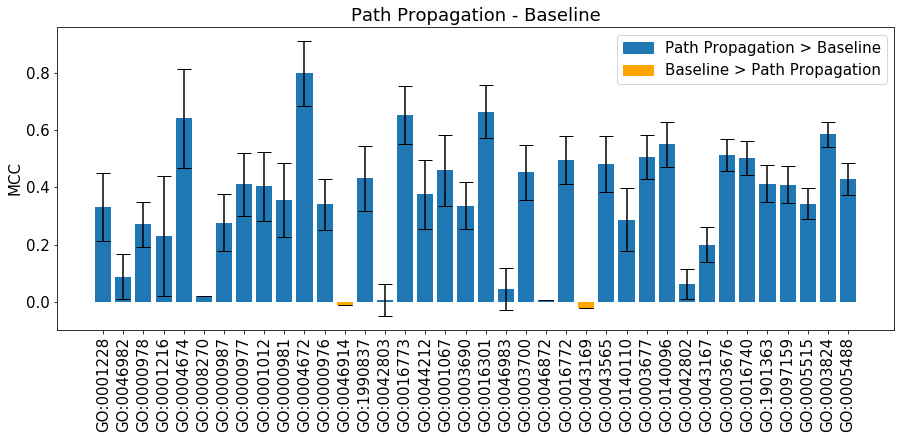

In [73]:
a=plt.figure(figsize=(15, 7))
terms = [i[0] for i in ordered_imbal]
probs = [dic_subtr[i[0]] for i in ordered_imbal]

plt.bar(terms, probs, color= ["#1f77b4" if i>0 else "orange" for i in probs ],yerr=error_mcc,capsize=7)
plt.rcParams.update({'font.size': 15})
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3, top=0.90)
plt.title('Path Propagation - Baseline')
plt.ylabel('MCC')
blue_patch = mpatches.Patch(color="#1f77b4", label='Path Propagation > Baseline')
orange_patch = mpatches.Patch(color='orange', label='Baseline > Path Propagation')
plt.legend(handles=[blue_patch, orange_patch])
plt.show()
a.savefig("../Figures/MCC_Path-Baseline.png")

## path probabilities f1 random

In [36]:
probs = [f1_dic[i[0]] for i in ordered_imbal]

In [37]:
error_f1 = [std_f1_pathbase[i[0]] for i in ordered_imbal]

In [38]:
dic_subtr = {}
for e, i in enumerate(dic_rand_f1):
    dic_subtr[i] = np.subtract(f1_dic[i], list(dic_rand_f1.values())[e])

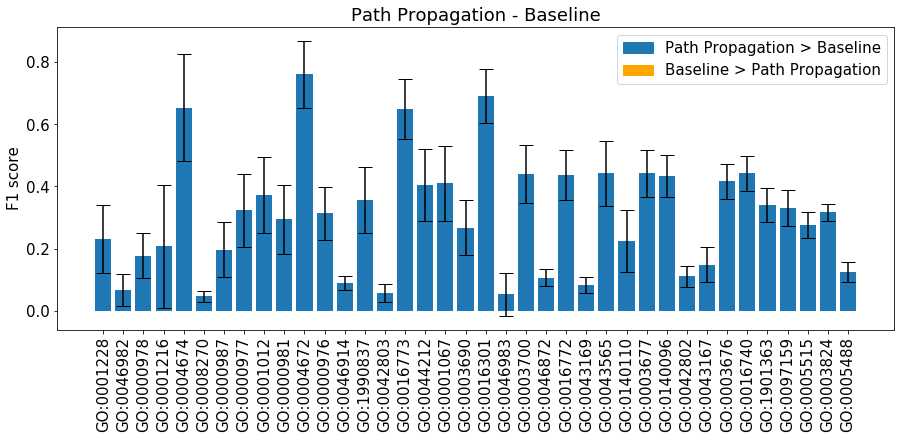

In [39]:
a=plt.figure(figsize=(15, 7))
terms = [i[0] for i in ordered_imbal]
probs = [dic_subtr[i[0]] for i in ordered_imbal]

plt.bar(terms, probs, color= ["#1f77b4" if i>0 else "orange" for i in probs ],yerr=error_f1,capsize=7)
plt.rcParams.update({'font.size': 15})
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3, top=0.90)
plt.title('Path Propagation - Baseline')
plt.ylabel('F1 score')
blue_patch = mpatches.Patch(color="#1f77b4", label='Path Propagation > Baseline')
orange_patch = mpatches.Patch(color='orange', label='Baseline > Path Propagation')
plt.legend(handles=[blue_patch, orange_patch])
plt.show()
a.savefig("../Figures/F1_Path-Baseline.png")

# path probabilities bacc averaged by distance

In [40]:
def getDepth(term):
    if term == "GO:0003674":
        return 0
    else:
        return 1+min(getDepth(i) for i in go[term]["is_a"])

In [41]:
depth = {}
for i in names:
    depth[i] = getDepth(i)

In [42]:
sortDepth = sorted(depth.items(), key=lambda item: item[1])

In [43]:
sortedBacc = [0 for i in range(8)]
counter = [0 for i in range(8)]

In [44]:
for i in sortDepth:
    counter[i[1]-1] += 1
    sortedBacc[i[1]-1] += bacc_dic[i[0]]
final_bacc = []
for i in range(len(sortedBacc)):
    final_bacc.append(sortedBacc[i]/counter[i])

In [45]:
final_bacc

[0.6964362042097361,
 0.7078668864876959,
 0.6742808848722475,
 0.7162729199838938,
 0.6884823623713161,
 0.7235698283693582,
 0.8180877652057125,
 0.84109754259008]

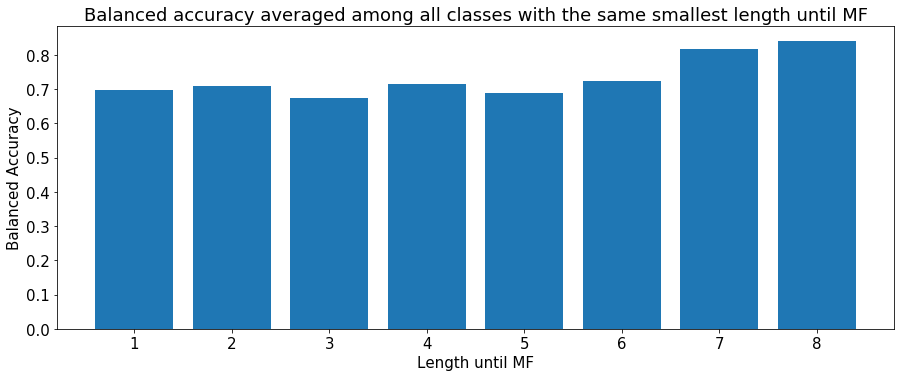

In [46]:
a=plt.figure(figsize=(15, 7))
terms = [i+1 for i in range(8)]
plt.bar(terms, final_bacc)
plt.rcParams.update({'font.size': 15})
plt.title('Balanced accuracy averaged among all classes with the same smallest length until MF')
plt.xlabel('Length until MF')
plt.ylabel('Balanced Accuracy')
plt.subplots_adjust(bottom=0.3, top=0.90)
plt.show()
#a.savefig("../Figures/bacc_path_root.png")

# path probabilities mcc averaged by distance

In [42]:
def getDepth(term):
    if term == "GO:0003674":
        return 0
    else:
        return 1+min(getDepth(i) for i in go[term]["is_a"])

In [43]:
depth = {}
for i in names:
    depth[i] = getDepth(i)

In [44]:
sortDepth = sorted(depth.items(), key=lambda item: item[1])

In [45]:
sortedMcc= [0 for i in range(8)]
counter = [0 for i in range(8)]

In [46]:
for i in sortDepth:
    counter[i[1]-1] += 1
    sortedMcc[i[1]-1] += mcc_dic[i[0]]
final_mcc = []
for i in range(len(sortedMcc)):
    final_mcc.append(sortedMcc[i]/counter[i])

In [47]:
final_mcc

[0.429423781001286,
 0.4105576416039322,
 0.3109385724807897,
 0.36861159240765917,
 0.312062591461953,
 0.28932789476174514,
 0.3412401821353818,
 0.25467835984409604]

# path probabilities f1 averaged by distance

In [47]:
def getDepth(term):
    if term == "GO:0003674":
        return 0
    else:
        return 1+min(getDepth(i) for i in go[term]["is_a"])

In [48]:
depth = {}
for i in names:
    depth[i] = getDepth(i)

In [49]:
sortDepth = sorted(depth.items(), key=lambda item: item[1])

In [50]:
sortedF1 = [0 for i in range(8)]
counter = [0 for i in range(8)]

In [51]:
for i in sortDepth:
    counter[i[1]-1] += 1
    sortedF1[i[1]-1] += f1_dic[i[0]]
final_f1 = []
for i in range(len(sortedF1)):
    final_f1.append(sortedF1[i]/counter[i])

In [52]:
final_f1

[0.5792375506134348,
 0.5149531273941494,
 0.36873132093627214,
 0.3966678045085019,
 0.3537590612387648,
 0.2927569790861002,
 0.29987629329734594,
 0.17647058823529413]

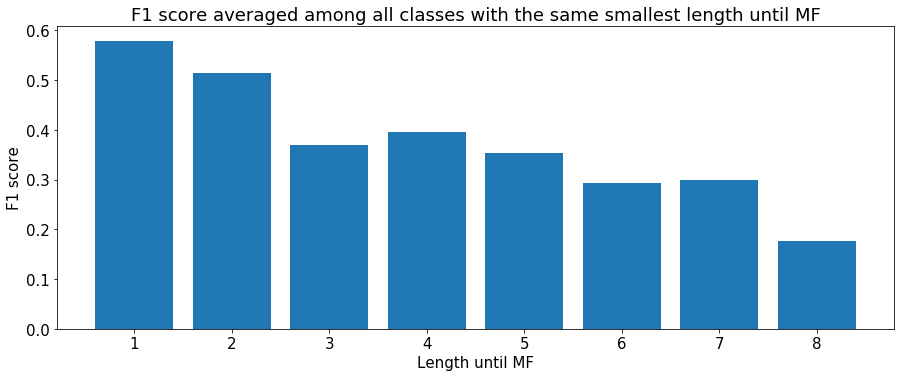

In [53]:
a=plt.figure(figsize=(15, 7))
terms = [i+1 for i in range(8)]
plt.bar(terms, final_f1)
plt.rcParams.update({'font.size': 15})
plt.title('F1 score averaged among all classes with the same smallest length until MF')
plt.xlabel('Length until MF')
plt.ylabel('F1 score')
plt.subplots_adjust(bottom=0.3, top=0.90)
plt.show()
#a.savefig("../Figures/f1_path_root.png")

# path probabilities recall averaged by distance

In [54]:
def getDepth(term):
    if term == "GO:0003674":
        return 0
    else:
        return 1+min(getDepth(i) for i in go[term]["is_a"])

In [55]:
depth = {}
for i in names:
    depth[i] = getDepth(i)

In [56]:
sortDepth = sorted(depth.items(), key=lambda item: item[1])

In [57]:
sortedRecall = [0 for i in range(8)]
counter = [0 for i in range(8)]

In [58]:
for i in sortDepth:
    counter[i[1]-1] += 1
    sortedRecall[i[1]-1] += recall_dic[i[0]]
final_recall = []
for i in range(len(sortedRecall)):
    final_recall.append(sortedRecall[i]/counter[i])

In [59]:
final_recall

[0.4809809685816864,
 0.538910644456521,
 0.5982292570218628,
 0.6282473034524908,
 0.6736638677862188,
 0.7471326164874552,
 0.709005376344086,
 0.8181818181818182]

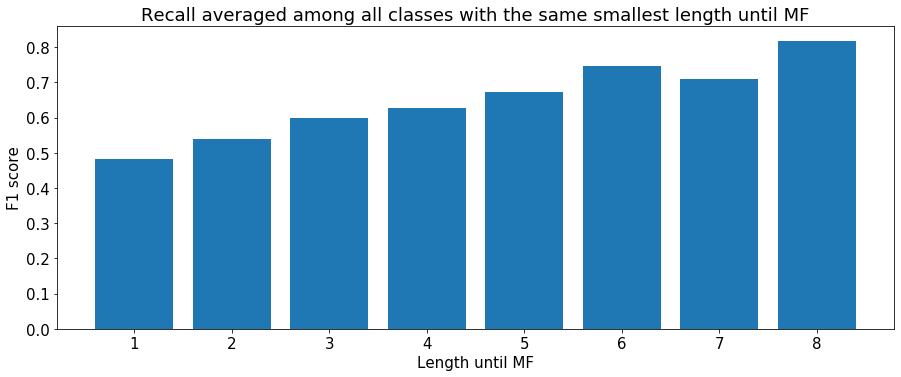

In [60]:
a=plt.figure(figsize=(15, 7))
terms = [i+1 for i in range(8)]
plt.bar(terms, final_recall)
plt.rcParams.update({'font.size': 15})
plt.title('Recall averaged among all classes with the same smallest length until MF')
plt.xlabel('Length until MF')
plt.ylabel('F1 score')
plt.subplots_adjust(bottom=0.3, top=0.90)
plt.show()
#a.savefig("../Figures/f1_path_root.png")

# Hierarchical algorithm

In [48]:
inv_map = {v: k for k, v in names.items()}

In [49]:
def getAncestors(id):
    term = go[id]
    parents = dict()
    return getParents(term, parents)

def getParents(term, parents):
    if term == 'GO:0003674':
        parents['GO:0003674'] = term
        return parents
    elif len(parents) == 0:
        parents[term['id']] = term
    for parent in term['is_a']:
        if parent not in parents:
            parents[parent] = go[parent]
            parents = getParents(go[parent], parents)
    return parents

In [50]:
with open("../3_go_dict/hierarchy.pkl", "rb") as f:
    go = pickle.load(f)

In [51]:
def getDepth(term):
    if term == "GO:0003674":
        return 0
    else:
        return 1+max(getDepth(i) for i in go[term]["is_a"])

In [52]:
classesDepth = {}
for i in names:
    classesDepth[i] = getDepth(i)

In [53]:
classSorted = [k for k,v in sorted(classesDepth.items(), key=lambda item: item[1])]

In [54]:
for i in classSorted:#i is go term; names[i] is number of go term
    vector_curr = dfModFinal["preds_"+str(names[i])].to_numpy().astype("int64")
    bitvec = np.zeros(len(dfModFinal), "int64")
    for j in go[i]["is_a"]:
        if j == "GO:0003674":
            bitvec = np.ones(len(dfModFinal), "int64")
        else:
            bitvec = bitvec | dfModFinal["preds_"+str(names[j])].to_numpy().astype("int64")
    final_vec = vector_curr & bitvec
    dfModFinal["hierarchical_"+str(names[i])] = final_vec

In [55]:
precision_h = []
recall_h = []
bacc_h = []
matthew_h = []
f1_h = []

f1_dic_h = {}
bacc_dic_h = {}
prec_dic_h = {}
recall_dic_h = {}
mcc_dic_h = {}

for i in range(38):
    y_test = dfModFinal["preds"].apply(lambda x: 1 if x[i]==1 else 0)            
    y_pred = dfModFinal["hierarchical_"+str(i)]

    precision_h.append(precision_score(y_test, y_pred))
    recall_h.append(recall_score(y_test, y_pred))
    bacc_h.append(balanced_accuracy_score(y_test, y_pred))
    matthew_h.append(matthews_corrcoef(y_test, y_pred))
    f1_h.append(f1_score(y_test, y_pred))
    
    f1_dic_h[name[i]] = f1_h[-1]
    bacc_dic_h[name[i]] = bacc_h[-1]
    prec_dic_h[name[i]] = precision_h[-1]
    recall_dic_h[name[i]] = recall_h[-1]
    mcc_dic_h[name[i]] = matthew_h[-1]

# Flat algorithm

In [56]:
precision_f = []
recall_f = []
bacc_f = []
matthew_f = []
f1_f = []

f1_dic_f = {}
bacc_dic_f = {}
prec_dic_f = {}
mcc_dic_f = {}
recall_dic_f = {}

for i in range(38):
    y_test = dfModFinal["preds"].apply(lambda x: 1 if x[i]==1 else 0)            
    y_pred = dfModFinal["preds_"+str(i)]

    precision_f.append(precision_score(y_test, y_pred))
    recall_f.append(recall_score(y_test, y_pred))
    bacc_f.append(balanced_accuracy_score(y_test, y_pred))
    matthew_f.append(matthews_corrcoef(y_test, y_pred))
    f1_f.append(f1_score(y_test, y_pred))
    
    f1_dic_f[name[i]] = f1_f[-1]
    bacc_dic_f[name[i]] = bacc_f[-1]
    prec_dic_f[name[i]] = precision_f[-1]
    recall_dic_f[name[i]] = recall_f[-1]
    mcc_dic_f[name[i]] = matthew_f[-1]

# hierarchical bacc averaged by distance

In [70]:
def getDepth(term):
    if term == "GO:0003674":
        return 0
    else:
        return 1+min(getDepth(i) for i in go[term]["is_a"])

In [71]:
depth = {}
for i in names:
    depth[i] = getDepth(i)

In [72]:
sortDepth = sorted(depth.items(), key=lambda item: item[1])

In [73]:
sortedBacc = [0 for i in range(8)]
counter = [0 for i in range(8)]

In [74]:
for i in sortDepth:
    counter[i[1]-1] += 1
    sortedBacc[i[1]-1] += bacc_dic_h[i[0]]
final_bacc_h = []
for i in range(len(sortedBacc)):
    final_bacc_h.append(sortedBacc[i]/counter[i])

In [75]:
final_bacc_h

[0.7177212746073159,
 0.6636112773256311,
 0.6781252956018882,
 0.6965927561352805,
 0.672321805894841,
 0.6775842563297949,
 0.7582187095959454,
 0.7136288255691241]

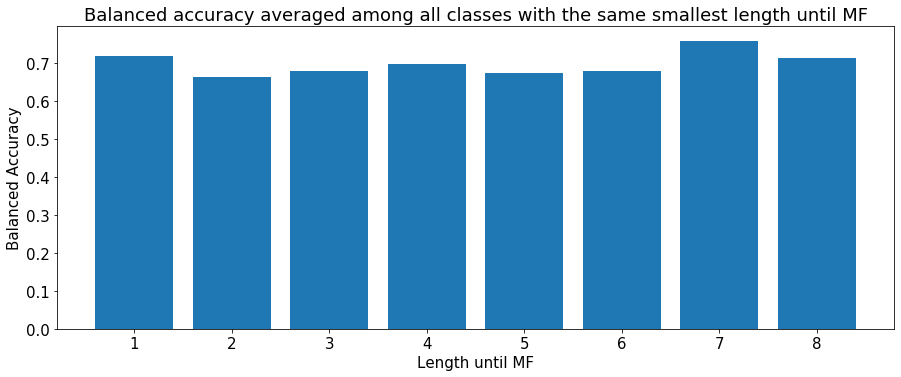

In [76]:
a=plt.figure(figsize=(15, 7))
terms = [i+1 for i in range(8)]
plt.bar(terms, final_bacc_h)
plt.rcParams.update({'font.size': 15})
plt.title('Balanced accuracy averaged among all classes with the same smallest length until MF')
plt.xlabel('Length until MF')
plt.ylabel('Balanced Accuracy')
plt.subplots_adjust(bottom=0.3, top=0.90)
plt.show()
#a.savefig("../Figures/bacc_path_root.png")

# hierarchical mcc averaged by distance

In [57]:
def getDepth(term):
    if term == "GO:0003674":
        return 0
    else:
        return 1+min(getDepth(i) for i in go[term]["is_a"])

In [58]:
depth = {}
for i in names:
    depth[i] = getDepth(i)

In [59]:
sortDepth = sorted(depth.items(), key=lambda item: item[1])

In [60]:
sortedMcc = [0 for i in range(8)]
counter = [0 for i in range(8)]

In [61]:
for i in sortDepth:
    counter[i[1]-1] += 1
    sortedMcc[i[1]-1] += mcc_dic_h[i[0]]
final_mcc_h = []
for i in range(len(sortedMcc)):
    final_mcc_h.append(sortedMcc[i]/counter[i])

In [62]:
final_mcc_h

[0.4642350512033433,
 0.3918148649199336,
 0.2889458393319031,
 0.28794466266301777,
 0.22514325154160317,
 0.18466574743753406,
 0.19706127187538874,
 0.12884952095435406]

# path probabilities f1 averaged by distance

In [77]:
def getDepth(term):
    if term == "GO:0003674":
        return 0
    else:
        return 1+min(getDepth(i) for i in go[term]["is_a"])

In [78]:
depth = {}
for i in names:
    depth[i] = getDepth(i)

In [79]:
sortDepth = sorted(depth.items(), key=lambda item: item[1])

In [80]:
sortedF1 = [0 for i in range(8)]
counter = [0 for i in range(8)]

In [81]:
for i in sortDepth:
    counter[i[1]-1] += 1
    sortedF1[i[1]-1] += f1_dic_h[i[0]]
final_f1_h = []
for i in range(len(sortedF1)):
    final_f1_h.append(sortedF1[i]/counter[i])

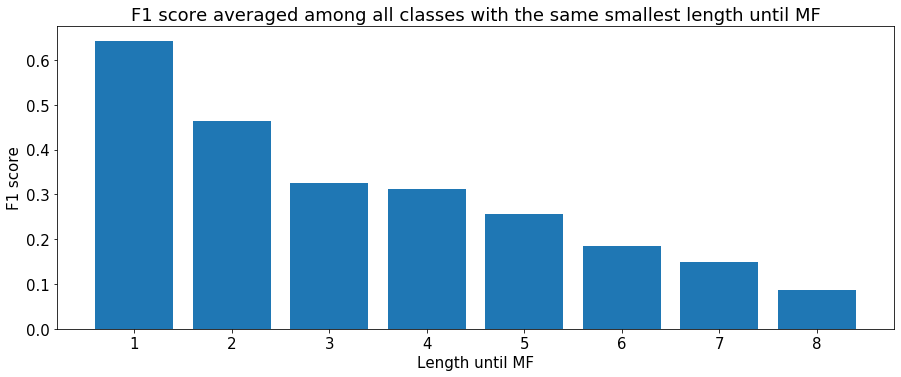

In [82]:
a=plt.figure(figsize=(15, 7))
terms = [i+1 for i in range(8)]
plt.bar(terms, final_f1_h)
plt.rcParams.update({'font.size': 15})
plt.title('F1 score averaged among all classes with the same smallest length until MF')
plt.xlabel('Length until MF')
plt.ylabel('F1 score')
plt.subplots_adjust(bottom=0.3, top=0.90)
plt.show()
#a.savefig("../Figures/f1_path_root.png")

# path probabilities recall averaged by distance

In [83]:
def getDepth(term):
    if term == "GO:0003674":
        return 0
    else:
        return 1+min(getDepth(i) for i in go[term]["is_a"])

In [84]:
depth = {}
for i in names:
    depth[i] = getDepth(i)

In [85]:
sortDepth = sorted(depth.items(), key=lambda item: item[1])

In [86]:
sortedRecall = [0 for i in range(8)]
counter = [0 for i in range(8)]

In [87]:
for i in sortDepth:
    counter[i[1]-1] += 1
    sortedRecall[i[1]-1] += recall_dic_h[i[0]]
final_recall_h = []
for i in range(len(sortedRecall)):
    final_recall_h.append(sortedRecall[i]/counter[i])

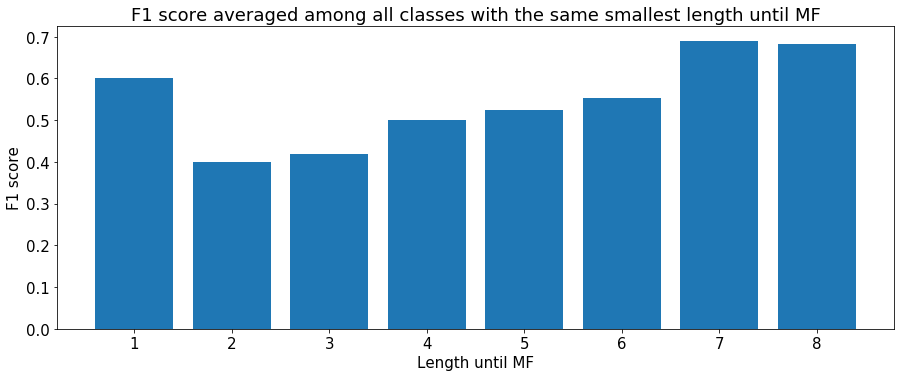

In [88]:
a=plt.figure(figsize=(15, 7))
terms = [i+1 for i in range(8)]
plt.bar(terms, final_recall_h)
plt.rcParams.update({'font.size': 15})
plt.title('F1 score averaged among all classes with the same smallest length until MF')
plt.xlabel('Length until MF')
plt.ylabel('F1 score')
plt.subplots_adjust(bottom=0.3, top=0.90)
plt.show()
#a.savefig("../Figures/f1_path_root.png")

# flat mcc averaged by distance

In [63]:
def getDepth(term):
    if term == "GO:0003674":
        return 0
    else:
        return 1+min(getDepth(i) for i in go[term]["is_a"])

In [64]:
depth = {}
for i in names:
    depth[i] = getDepth(i)

In [65]:
sortDepth = sorted(depth.items(), key=lambda item: item[1])

In [66]:
sortedMcc = [0 for i in range(8)]
counter = [0 for i in range(8)]

In [67]:
for i in sortDepth:
    counter[i[1]-1] += 1
    sortedMcc[i[1]-1] += mcc_dic_f[i[0]]
final_mcc_f = []
for i in range(len(sortedMcc)):
    final_mcc_f.append(sortedMcc[i]/counter[i])

In [68]:
final_mcc_f

[0.4642350512033433,
 0.2879330803007808,
 0.2140136828028008,
 0.16130398854454095,
 0.14733782323553382,
 0.11317800929130342,
 0.14550689357551855,
 0.07624791029925669]

# flat bacc averaged by distance

In [89]:
def getDepth(term):
    if term == "GO:0003674":
        return 0
    else:
        return 1+min(getDepth(i) for i in go[term]["is_a"])

In [90]:
depth = {}
for i in names:
    depth[i] = getDepth(i)

In [91]:
sortDepth = sorted(depth.items(), key=lambda item: item[1])

In [92]:
sortedBacc = [0 for i in range(8)]
counter = [0 for i in range(8)]

In [93]:
for i in sortDepth:
    counter[i[1]-1] += 1
    sortedBacc[i[1]-1] += bacc_dic_f[i[0]]
final_bacc_f = []
for i in range(len(sortedBacc)):
    final_bacc_f.append(sortedBacc[i]/counter[i])

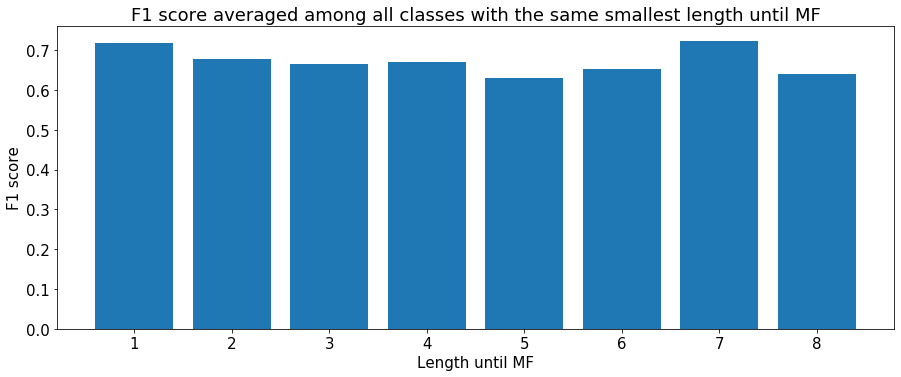

In [94]:
a=plt.figure(figsize=(15, 7))
terms = [i+1 for i in range(8)]
plt.bar(terms, final_bacc_f)
plt.rcParams.update({'font.size': 15})
plt.title('F1 score averaged among all classes with the same smallest length until MF')
plt.xlabel('Length until MF')
plt.ylabel('F1 score')
plt.subplots_adjust(bottom=0.3, top=0.90)
plt.show()
#a.savefig("../Figures/f1_path_root.png")

# flat f1 averaged by distance

In [95]:
def getDepth(term):
    if term == "GO:0003674":
        return 0
    else:
        return 1+min(getDepth(i) for i in go[term]["is_a"])

In [96]:
depth = {}
for i in names:
    depth[i] = getDepth(i)

In [97]:
sortDepth = sorted(depth.items(), key=lambda item: item[1])

In [98]:
sortedF1 = [0 for i in range(8)]
counter = [0 for i in range(8)]

In [99]:
for i in sortDepth:
    counter[i[1]-1] += 1
    sortedF1[i[1]-1] += f1_dic_f[i[0]]
final_f1_f = []
for i in range(len(sortedBacc)):
    final_f1_f.append(sortedF1[i]/counter[i])

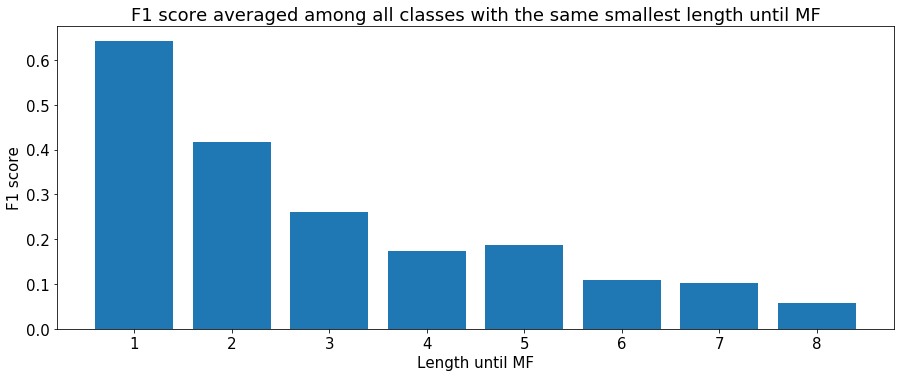

In [100]:
a=plt.figure(figsize=(15, 7))
terms = [i+1 for i in range(8)]
plt.bar(terms, final_f1_f)
plt.rcParams.update({'font.size': 15})
plt.title('F1 score averaged among all classes with the same smallest length until MF')
plt.xlabel('Length until MF')
plt.ylabel('F1 score')
plt.subplots_adjust(bottom=0.3, top=0.90)
plt.show()
#a.savefig("../Figures/f1_path_root.png")

# Combine Hierarchical and Path F1 score

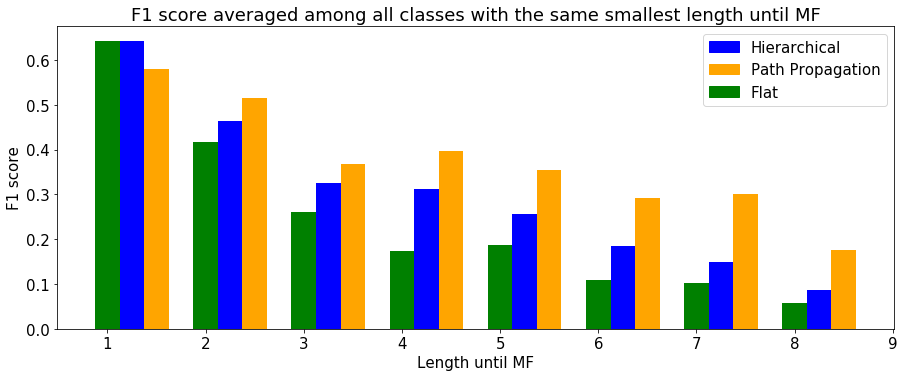

In [101]:
a=plt.figure(figsize=(15, 7))
terms = [i+1 for i in range(8)]
X = np.arange(8)+1
plt.bar(X + 0.25, final_f1_h, color = 'b', width = 0.25)
plt.bar(X + 0.50, final_f1, color = 'orange', width = 0.25)
plt.bar(X + 0.00, final_f1_f, color = 'green', width = 0.25)

plt.rcParams.update({'font.size': 15})
plt.title('F1 score averaged among all classes with the same smallest length until MF')
plt.xlabel('Length until MF')
plt.ylabel('F1 score')
plt.subplots_adjust(bottom=0.3, top=0.90)
blue_patch = mpatches.Patch(color="b", label='Hierarchical')
red_patch = mpatches.Patch(color='orange', label='Path Propagation')
green_patch = mpatches.Patch(color='green', label='Flat')
plt.legend(handles=[blue_patch, red_patch, green_patch])
plt.show()
a.savefig("../Figures/f1_distance_comparison.png")

# combine balanced accuracies

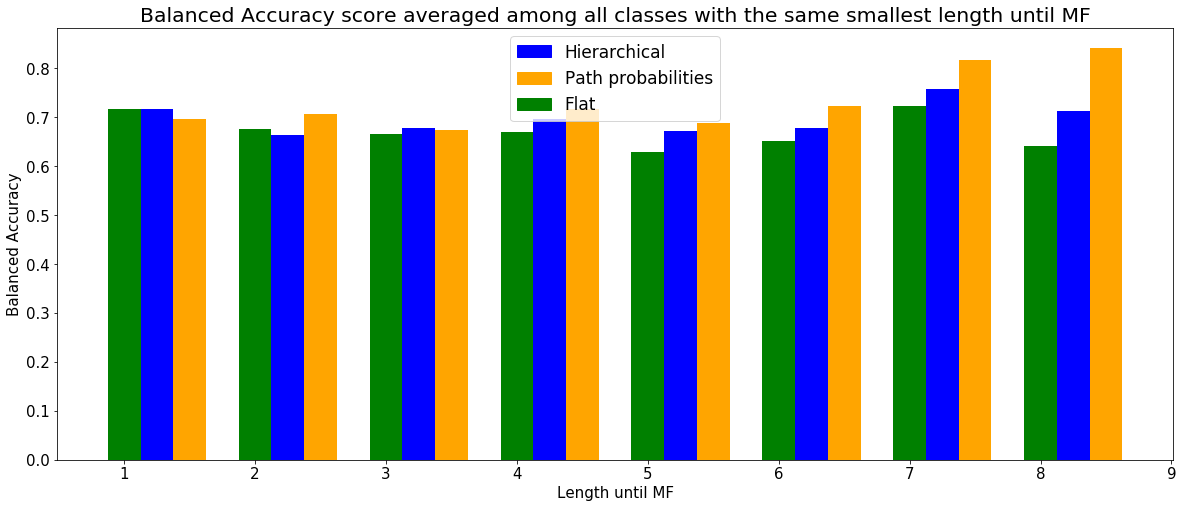

In [102]:
a=plt.figure(figsize=(20, 10))
terms = [i+1 for i in range(8)]
X = np.arange(8)+1
plt.bar(X + 0.25, final_bacc_h, color = 'b', width = 0.25)
plt.bar(X + 0.5, final_bacc, color = 'orange', width = 0.25)
plt.bar(X + 0.00, final_bacc_f, color = 'g', width = 0.25)

plt.rcParams.update({'font.size': 17})
plt.title('Balanced Accuracy score averaged among all classes with the same smallest length until MF')
plt.xlabel('Length until MF')
plt.ylabel('Balanced Accuracy')
plt.subplots_adjust(bottom=0.3, top=0.90)
blue_patch = mpatches.Patch(color="b", label='Hierarchical')
red_patch = mpatches.Patch(color='orange', label='Path probabilities')
green_patch = mpatches.Patch(color='green', label='Flat')
plt.legend(handles=[blue_patch, red_patch, green_patch])
plt.show()
#a.savefig("../Figures/bacc_distance_comparison.png")

# Combine Hierarchical and Path MCC

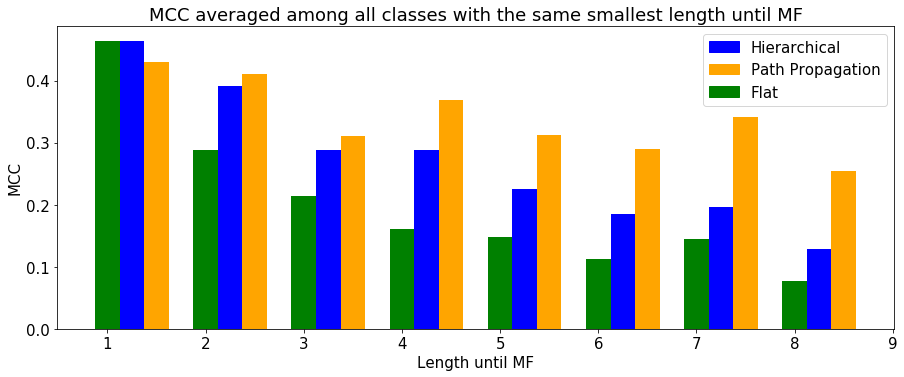

In [72]:
a=plt.figure(figsize=(15, 7))
terms = [i+1 for i in range(8)]
X = np.arange(8)+1
plt.bar(X + 0.25, final_mcc_h, color = 'b', width = 0.25)
plt.bar(X + 0.50, final_mcc, color = 'orange', width = 0.25)
plt.bar(X + 0.00, final_mcc_f, color = 'green', width = 0.25)

plt.rcParams.update({'font.size': 15})
plt.title('MCC averaged among all classes with the same smallest length until MF')
plt.xlabel('Length until MF')
plt.ylabel('MCC')
plt.subplots_adjust(bottom=0.3, top=0.90)
blue_patch = mpatches.Patch(color="b", label='Hierarchical')
red_patch = mpatches.Patch(color='orange', label='Path Propagation')
green_patch = mpatches.Patch(color='green', label='Flat')
plt.legend(handles=[blue_patch, red_patch, green_patch])
plt.show()
a.savefig("../Figures/mcc_distance_comparison.png")

# Standard error flat

In [103]:
score_total_f1 = {}
score_total_bacc = {}
score_total_mcc = {}

for name in names:
    scores_f1 = []
    scores_mcc = []
    scores_bacc = []
    for i in range(100):
        dfsamples = dfModFinal.sample(n=300, replace=True)
        y_test = dfsamples["preds"].apply(lambda x: 1 if x[names[name]]==1 else 0)  
        y_pred = dfsamples["preds_"+str(names[name])]
        scores_f1.append(f1_score(y_test, y_pred))
        scores_mcc.append(matthews_corrcoef(y_test, y_pred))
        scores_bacc.append(balanced_accuracy_score(y_test, y_pred))
    score_total_f1[name] = scores_f1
    score_total_mcc[name] = scores_mcc
    score_total_bacc[name] = scores_bacc

In [104]:
array_f1 = np.array([score_total_f1[i] for i in score_total_f1])

In [105]:
np.average(array_f1.flatten())

0.2604942486432644

In [106]:
np.std(array_f1.flatten())

0.20399545834022478

In [107]:
array_mcc = np.array([score_total_mcc[i] for i in score_total_mcc])

In [108]:
np.average(array_mcc.flatten())

0.20930580318165737

In [109]:
np.std(array_mcc.flatten())

0.16619187175039676

In [110]:
array_bacc = np.array([score_total_bacc[i] for i in score_total_bacc])

In [111]:
np.average(array_bacc.flatten())

0.6702014633145755

In [112]:
np.std(array_bacc.flatten())

0.11867422426714408

# Standard error hier

In [113]:
score_total_f1_h = {}
score_total_bacc_h = {}
score_total_mcc_h = {}

for name in names:
    scores_f1 = []
    scores_mcc = []
    scores_bacc = []
    for i in range(100):
        dfsamples = dfModFinal.sample(n=300, replace=True)
        y_test = dfsamples["preds"].apply(lambda x: 1 if x[names[name]]==1 else 0)  
        y_pred = dfsamples["hierarchical_"+str(names[name])]
        scores_f1.append(f1_score(y_test, y_pred))
        scores_mcc.append(matthews_corrcoef(y_test, y_pred))
        scores_bacc.append(balanced_accuracy_score(y_test, y_pred))
    score_total_f1_h[name] = scores_f1
    score_total_mcc_h[name] = scores_mcc
    score_total_bacc_h[name] = scores_bacc

In [114]:
array_f1 = np.array([score_total_f1_h[i] for i in score_total_f1_h])

In [115]:
np.average(array_f1.flatten())

0.3321649268636984

In [116]:
np.std(array_f1.flatten())

0.22258918985638212

In [117]:
array_mcc = np.array([score_total_mcc_h[i] for i in score_total_mcc_h])

In [118]:
np.average(array_mcc.flatten())

0.29365266219826786

In [119]:
np.std(array_mcc.flatten())

0.19909806483003833

In [120]:
array_bacc = np.array([score_total_bacc_h[i] for i in score_total_bacc_h])

In [121]:
np.average(array_bacc.flatten())

0.6882108578669375

In [122]:
np.std(array_bacc.flatten())

0.12252648490330947

# Standard error path

In [123]:
score_total_f1_p = {}
score_total_bacc_p = {}
score_total_mcc_p = {}

for name in names:
    scores_f1 = []
    scores_mcc = []
    scores_bacc = []
    for i in range(100):
        dfsamples = dfModFinal.sample(n=300, replace=True)
        y_test = dfsamples["preds"].apply(lambda x: 1 if x[names[name]]==1 else 0)  
        y_pred = dfsamples["final_"+str(names[name])]
        scores_f1.append(f1_score(y_test, y_pred))
        scores_mcc.append(matthews_corrcoef(y_test, y_pred))
        scores_bacc.append(balanced_accuracy_score(y_test, y_pred))
    score_total_f1_p[name] = scores_f1
    score_total_mcc_p[name] = scores_mcc
    score_total_bacc_p[name] = scores_bacc

In [124]:
array_f1 = np.array([score_total_f1_p[i] for i in score_total_f1_p])

In [125]:
np.average(array_f1.flatten())

0.39518598840360697

In [126]:
np.std(array_f1.flatten())

0.22793337391351082

In [127]:
array_mcc = np.array([score_total_mcc_p[i] for i in score_total_mcc_p])

In [128]:
np.average(array_mcc.flatten())

0.3468141939958632

In [129]:
np.std(array_mcc.flatten())

0.22916525907114962

In [130]:
array_bacc = np.array([score_total_bacc_p[i] for i in score_total_bacc_p])

In [131]:
np.average(array_bacc.flatten())

0.7110820517136512

In [132]:
np.std(array_bacc.flatten())

0.13537620807864922

# combine bacc for all classes

In [133]:
bacc_p = [bacc_dic[i[0]] for i in ordered_imbal]
bacc_h = [bacc_dic_h[i[0]] for i in ordered_imbal]
bacc_f = [bacc_dic_f[i[0]] for i in ordered_imbal]

In [134]:
f1_p = [f1_dic[i[0]] for i in ordered_imbal]
f1_h = [f1_dic_h[i[0]] for i in ordered_imbal]
f1_f = [f1_dic_f[i[0]] for i in ordered_imbal]

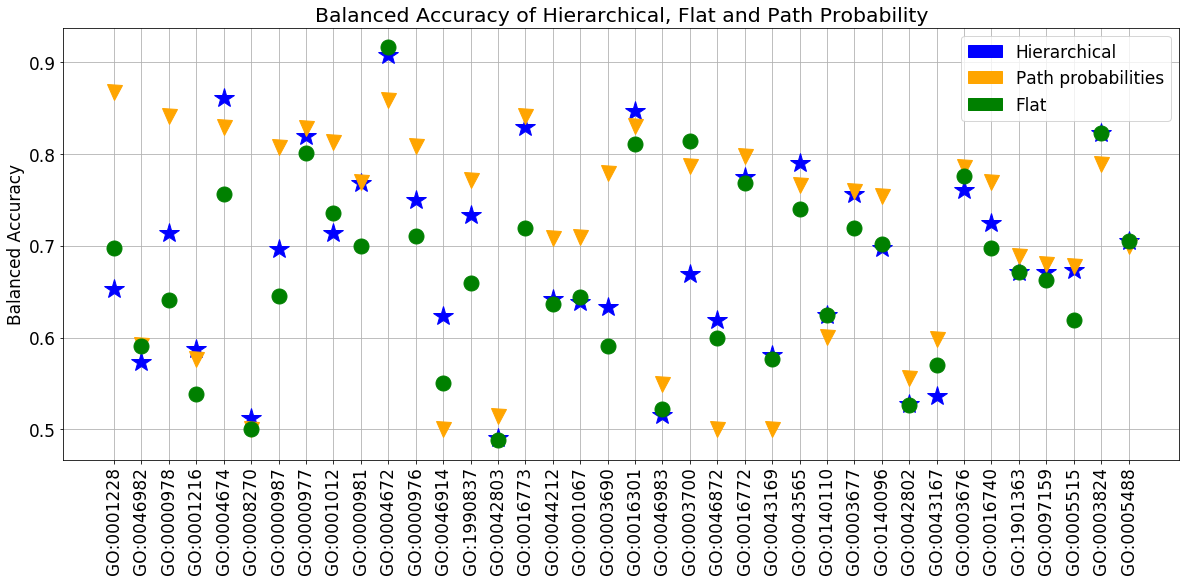

In [135]:
a=plt.figure(figsize=(20, 10))
terms = [i+1 for i in range(8)]
X = np.arange(8)+1
marker_style = dict(linestyle=':', color='0.8', markersize=20,
                    mfc="C0", mec="C0")
marker_style.update(mec="None", markersize=15)
terms = [i[0] for i in ordered_imbal]
plt.plot(terms, bacc_h, color = 'b', marker="*", linestyle="None", markersize=20)
plt.plot(terms, bacc_p, color = 'orange', marker="v", linestyle="None", markersize=15)
plt.plot(terms, bacc_f, color = 'g', marker="o", linestyle="None", markersize=15)
plt.rcParams.update({'font.size': 17})
plt.title('Balanced Accuracy of Hierarchical, Flat and Path Probability')
plt.ylabel('Balanced Accuracy')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3, top=0.90)
blue_patch = mpatches.Patch(color="b", label='Hierarchical')
red_patch = mpatches.Patch(color='orange', label='Path probabilities')
green_patch = mpatches.Patch(color='green', label='Flat')
plt.legend(handles=[blue_patch, red_patch, green_patch])
plt.grid(True)
plt.show()
#a.savefig("../Figures/bacc_distance_comparison.png")

In [136]:
yerr_h = [np.std(score_total_f1_h[i[0]]) for i in ordered_imbal]
values_h = [np.average(score_total_f1_h[i[0]]) for i in ordered_imbal]

In [137]:
yerr_p = [np.std(score_total_f1_p[i[0]]) for i in ordered_imbal]
values_p = [np.average(score_total_f1_p[i[0]]) for i in ordered_imbal]

In [138]:
yerr_f = [np.std(score_total_f1[i[0]]) for i in ordered_imbal]
values_f = [np.average(score_total_f1[i[0]]) for i in ordered_imbal]

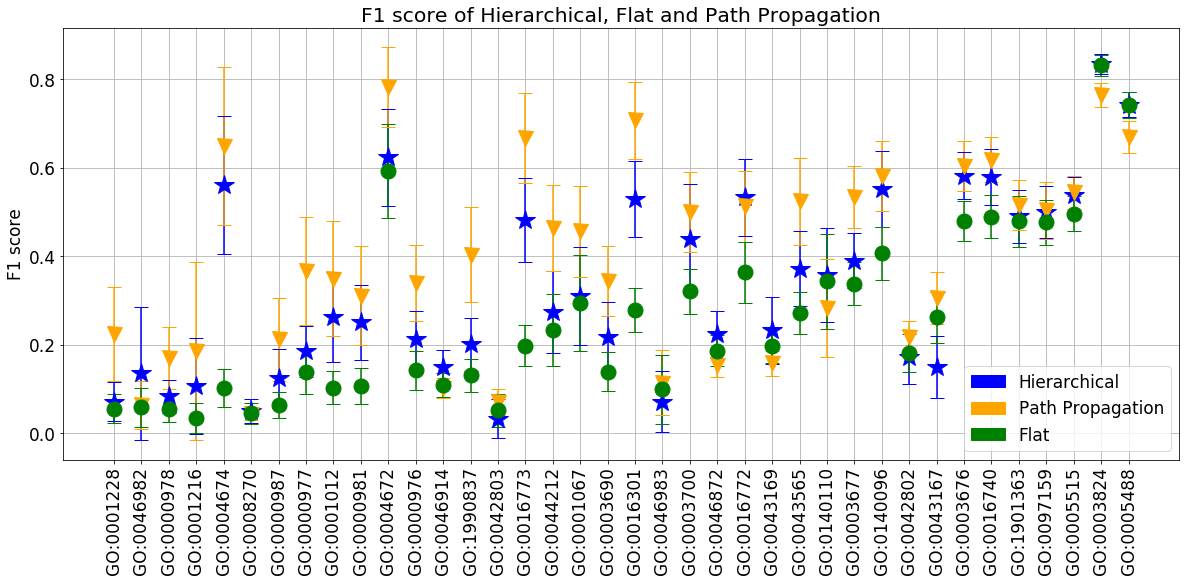

In [139]:
a=plt.figure(figsize=(20, 10))
terms = [i+1 for i in range(8)]
X = np.arange(8)+1
marker_style = dict(linestyle=':', color='0.8', markersize=20,
                    mfc="C0", mec="C0")
marker_style.update(mec="None", markersize=15)
terms = [i[0] for i in ordered_imbal]
plt.errorbar(terms, values_h, color = 'b', marker="*", linestyle="None", markersize=20, yerr = yerr_h, capsize = 7)
plt.errorbar(terms, values_p, color = 'orange', marker="v", linestyle="None", markersize=15, yerr = yerr_p, capsize = 7)
plt.errorbar(terms, values_f, color = 'g', marker="o", linestyle="None", markersize=15, yerr = yerr_f, capsize = 7)
plt.rcParams.update({'font.size': 17})
plt.title('F1 score of Hierarchical, Flat and Path Propagation')
plt.ylabel('F1 score')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3, top=0.90)
blue_patch = mpatches.Patch(color="b", label='Hierarchical')
red_patch = mpatches.Patch(color='orange', label='Path Propagation')
green_patch = mpatches.Patch(color='green', label='Flat')
plt.legend(handles=[blue_patch, red_patch, green_patch])
plt.grid(True)
plt.show()
a.savefig("../Figures/None_f1_distance_comparison.png")

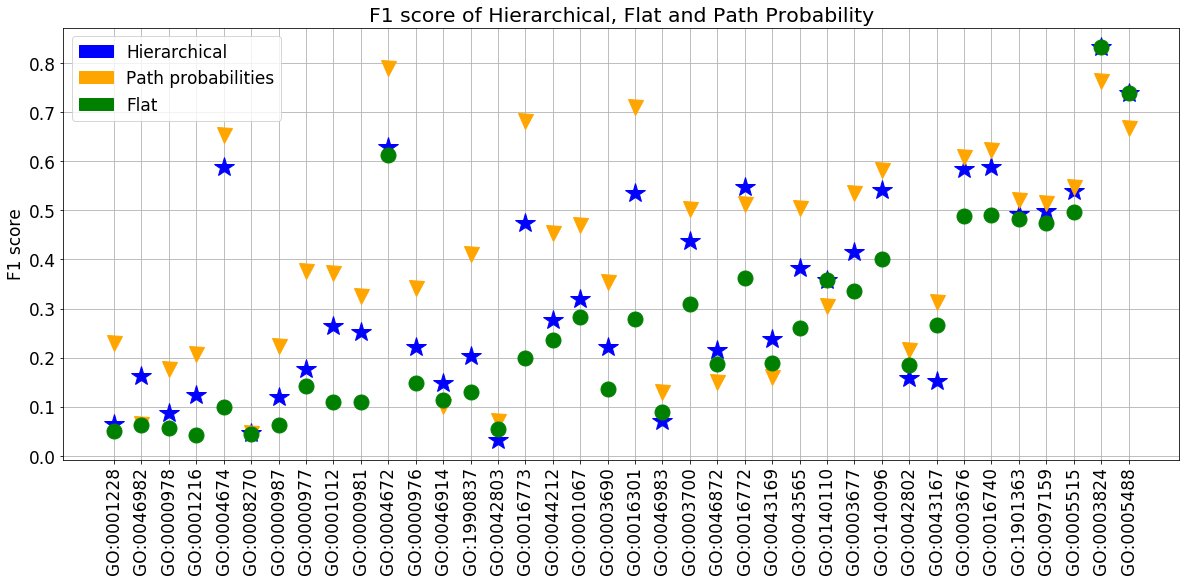

In [140]:
a=plt.figure(figsize=(20, 10))
terms = [i+1 for i in range(8)]
X = np.arange(8)+1
marker_style = dict(linestyle=':', color='0.8', markersize=20,
                    mfc="C0", mec="C0")
marker_style.update(mec="None", markersize=15)
terms = [i[0] for i in ordered_imbal]
plt.plot(terms, f1_h, color = 'b', marker="*", linestyle="None", markersize=20)
plt.plot(terms, f1_p, color = 'orange', marker="v", linestyle="None", markersize=15)
plt.plot(terms, f1_f, color = 'g', marker="o", linestyle="None", markersize=15)
plt.rcParams.update({'font.size': 17})
plt.title('F1 score of Hierarchical, Flat and Path Probability')
plt.ylabel('F1 score')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3, top=0.90)
blue_patch = mpatches.Patch(color="b", label='Hierarchical')
red_patch = mpatches.Patch(color='orange', label='Path probabilities')
green_patch = mpatches.Patch(color='green', label='Flat')
plt.legend(handles=[blue_patch, red_patch, green_patch])
plt.grid(True)
plt.show()
#a.savefig("../Figures/None_f1_distance_comparison.png")

# combine f1 for all classes

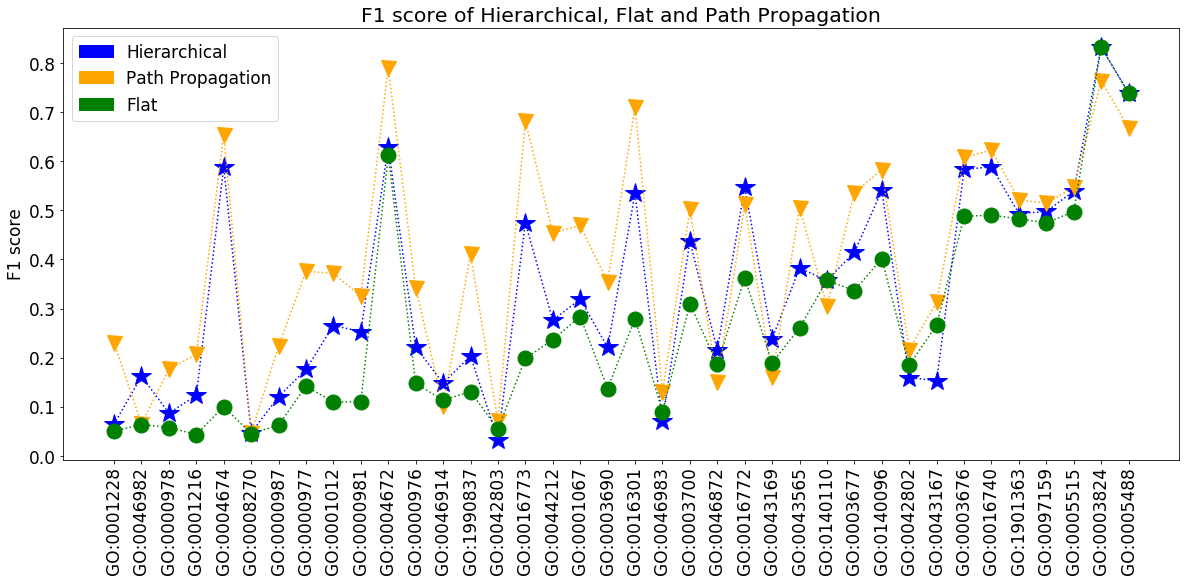

In [141]:
a=plt.figure(figsize=(20, 10))
terms = [i+1 for i in range(8)]
X = np.arange(8)+1
marker_style = dict(linestyle=':', color='0.8', markersize=20,
                    mfc="C0", mec="C0")
marker_style.update(mec="None", markersize=15)
terms = [i[0] for i in ordered_imbal]
plt.plot(terms, f1_h, color = 'b', marker="*", linestyle="dotted", markersize=20)
plt.plot(terms, f1_p, color = 'orange', marker="v", linestyle="dotted", markersize=15)
plt.plot(terms, f1_f, color = 'g', marker="o", linestyle="dotted", markersize=15)
plt.rcParams.update({'font.size': 17})
plt.title('F1 score of Hierarchical, Flat and Path Propagation')
plt.ylabel('F1 score')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3, top=0.90)
blue_patch = mpatches.Patch(color="b", label='Hierarchical')
red_patch = mpatches.Patch(color='orange', label='Path Propagation')
green_patch = mpatches.Patch(color='green', label='Flat')
plt.legend(handles=[blue_patch, red_patch, green_patch])
plt.show()
#a.savefig("../Figures/f1_hier_flat_path.png")

# how classifiers can distinguish between parents and child

In [142]:
f1 = []
mcc = []
bacc = []
acc = {}
for i in range(38):
    truths = np.zeros(len(dfModFinal), int)
    for j in go[list(names.keys())[i]]["is_a"]:
        if j!= "GO:0003674":
            pos = names[j]
            truths = truths | dfModFinal["preds"].apply(lambda x: 1 if x[pos]==1 else 0)
        else:
            truths = np.ones(len(dfModFinal), int)
    truth = [True if x==1 else False for x in truths]
    dfDistinguish = dfModFinal[truth]
    y_test = dfDistinguish["preds"].apply(lambda x: 1 if x[i]==1 else 0)  
    y_pred = dfDistinguish["preds_"+str(i)]
    #f1[list(names.keys())[i]] = f1_score(y_test, y_pred)
    f1.append(f1_score(y_test, y_pred))
    bacc.append(balanced_accuracy_score(y_test, y_pred))
    mcc.append(matthews_corrcoef(y_test, y_pred))

In [143]:
np.average(f1), np.std(f1)

(0.6434494856886558, 0.2043870697980047)

In [144]:
np.average(bacc), np.std(bacc)

(0.6737107053395534, 0.11502080166698093)

In [145]:
np.average(mcc), np.std(mcc)

(0.36386100984912634, 0.22385520703188339)

# Look at differences between top level classes binding, catalytic activity and transcription factor regulation

In [149]:
#3824 5488 140110

In [150]:
def getAncestors(id):
    term = go[id]
    parents = dict()
    return getParents(term, parents)

def getParents(term, parents):
    if term == 'GO:0003674':
        parents['GO:0003674'] = term
        return parents
    elif len(parents) == 0:
        parents[term['id']] = term
    for parent in term['is_a']:
        if parent not in parents:
            parents[parent] = go[parent]
            parents = getParents(go[parent], parents)
    return parents

# F1 score

In [151]:
binding, catalytic, transcription = [0,0,0]
binding_f = []
binding_h = []
binding_p = []
catalytic_f = []
catalytic_h = []
catalytic_p = []
transcription_f = []
transcription_h = []
transcription_p = []
for i in names:
    anc = getAncestors(i)
    if "GO:0005488" in anc:
        binding += 1
        binding_f.append(f1_dic_f[i])
        binding_h.append(f1_dic_h[i])
        binding_p.append(f1_dic[i])
    if "GO:0140110" in anc:
        transcription += 1
        transcription_f.append(f1_dic_f[i])
        transcription_h.append(f1_dic_h[i])
        transcription_p.append(f1_dic[i])
    if "GO:0003824" in anc:
        catalytic += 1
        catalytic_f.append(f1_dic_f[i])
        catalytic_h.append(f1_dic_h[i])
        catalytic_p.append(f1_dic[i])

In [152]:
binding

25

In [153]:
catalytic

8

In [154]:
transcription

5

# Bacc

In [118]:
binding_f = []
binding_h = []
binding_p = []
catalytic_f = []
catalytic_h = []
catalytic_p = []
transcription_f = []
transcription_h = []
transcription_p = []
for i in names:
    anc = getAncestors(i)
    if "GO:0005488" in anc:
        binding_f.append(bacc_dic_f[i])
        binding_h.append(bacc_dic_h[i])
        binding_p.append(bacc_dic[i])
    if "GO:0140110" in anc:
        transcription_f.append(bacc_dic_f[i])
        transcription_h.append(bacc_dic_h[i])
        transcription_p.append(bacc_dic[i])
    if "GO:0003824" in anc:
        catalytic_f.append(bacc_dic_f[i])
        catalytic_h.append(bacc_dic_h[i])
        catalytic_p.append(bacc_dic[i])

In [155]:
np.average(binding_f)

0.23127396848898726

In [156]:
np.std(binding_f)

0.17595026922417553

In [157]:
np.average(transcription_f)

0.17430537327166915

In [158]:
np.std(transcription_f)

0.13298677128205602

In [159]:
np.average(catalytic_f)

0.4096817896686449

In [160]:
np.std(catalytic_f)

0.2195528362228826

In [161]:
np.average(binding_h)

0.27078581291295445

In [162]:
np.std(binding_h)

0.17932154799661573

In [163]:
np.average(transcription_h)

0.2470696586053816

In [164]:
np.std(transcription_h)

0.13929936573883694

In [165]:
np.average(catalytic_h)

0.5920752418134083

In [166]:
np.std(catalytic_h)

0.10059590469516301

In [167]:
np.average(binding_p)

0.3333562978087943

In [168]:
np.std(binding_p)

0.18410533408523413

In [169]:
np.average(transcription_p)

0.31414798065448146

In [170]:
np.std(transcription_p)

0.10412099895098598

In [171]:
np.average(catalytic_p)

0.6649856674129031

In [172]:
np.std(catalytic_p)

0.08654870172005258

# Test Validation Set without path multiplication

In [39]:
precision = []
recall = []
bacc = []
matthew = []
f1 = []

precision_dic_old = {}
recall_dic_old = {}
bacc_dic_old = {}
matthew_dic_old = {}
f1_dic_old = {}


for i in range(38):
    y_test = dfMod["preds"].apply(lambda x: 1 if x[i]==1 else 0)            

    y_pred = [1  if j > 0.5 else 0 for j in dfMod["predProba_"+str(i)]]

    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    bacc.append(balanced_accuracy_score(y_test, y_pred))
    matthew.append(matthews_corrcoef(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    
    precision_dic_old[name[i]] = precision[-1]
    recall_dic_old[name[i]] = recall[-1]
    bacc_dic_old[name[i]] = bacc[-1]
    f1_dic_old[name[i]] = f1[-1]
    matthew_dic_old[name[i]] = matthew[-1]

In [40]:
np.average(f1)

0.2577389788036034

In [41]:
np.average(precision)

0.20414322944444332

In [42]:
np.average(recall)

0.6146333533237552

In [43]:
np.average(bacc)

0.6685340313141355

In [44]:
np.average(matthew)

0.2121061244657236

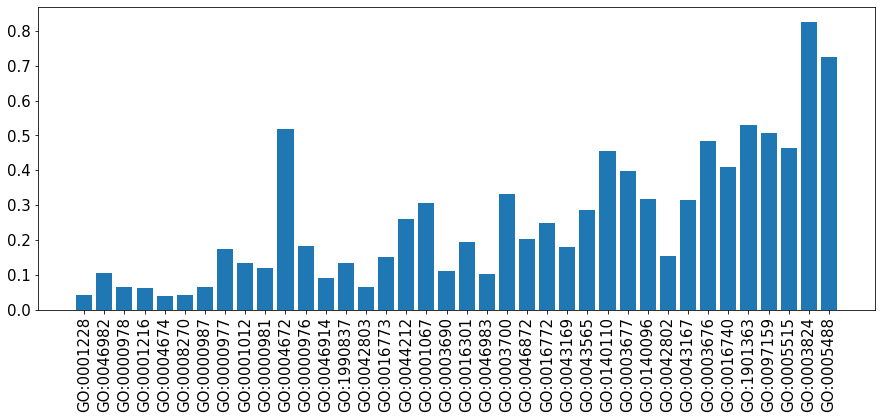

In [85]:
a=plt.figure(figsize=(15, 7))
terms = [i[0] for i in ordered_imbal]
probs = [f1_dic_old[i[0]] for i in ordered_imbal]
plt.bar(terms, probs)
plt.rcParams.update({'font.size': 15})
plt.xticks(rotation=90)
#plt.yscale('log')
plt.subplots_adjust(bottom=0.3, top=0.90)

plt.show()

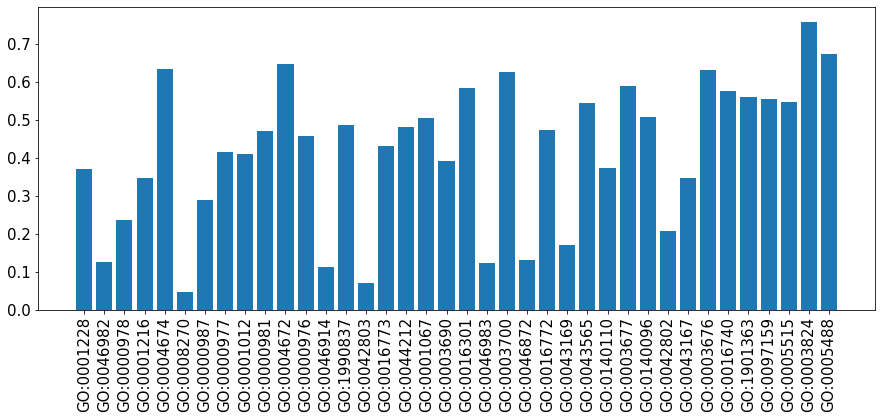

In [59]:
a=plt.figure(figsize=(15, 7))
terms = [i[0] for i in ordered_imbal]
probs = [f1_dic[i[0]] for i in ordered_imbal]
plt.bar(terms, probs)
plt.rcParams.update({'font.size': 15})
plt.xticks(rotation=90)
#plt.yscale('log')
plt.subplots_adjust(bottom=0.3, top=0.90)

plt.show()

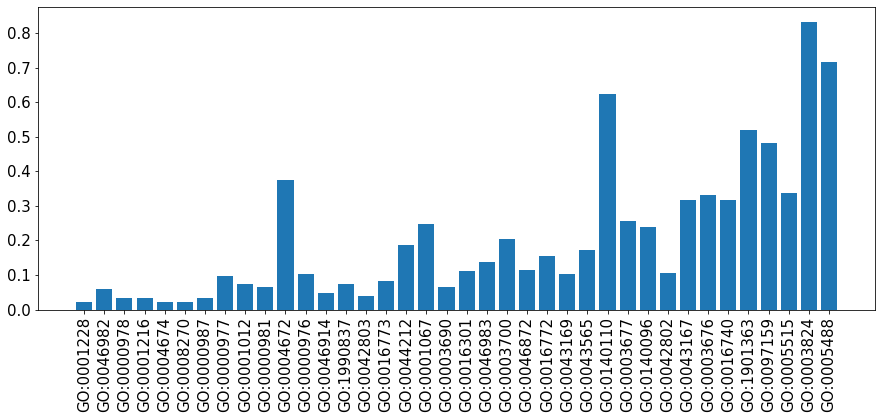

In [86]:
a=plt.figure(figsize=(15, 7))
terms = [i[0] for i in ordered_imbal]
probs = [precision_dic_old[i[0]] for i in ordered_imbal]
plt.bar(terms, probs)
plt.rcParams.update({'font.size': 15})
plt.xticks(rotation=90)
#plt.yscale('log')
plt.subplots_adjust(bottom=0.3, top=0.90)

plt.show()

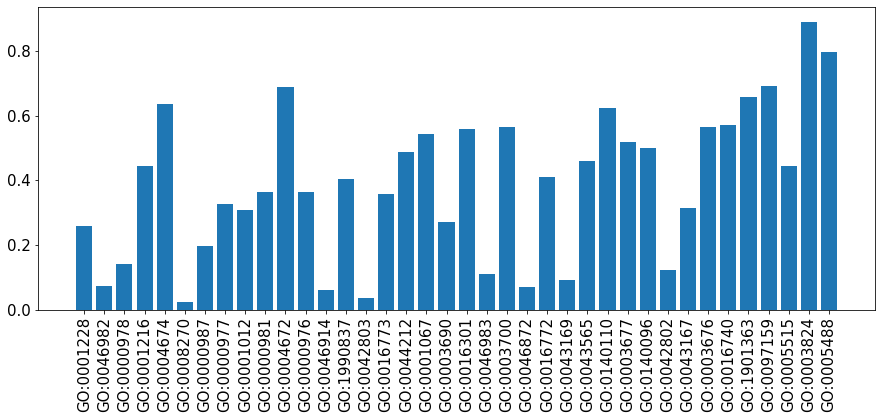

In [60]:
a=plt.figure(figsize=(15, 7))
terms = [i[0] for i in ordered_imbal]
probs = [precision_dic[i[0]] for i in ordered_imbal]
plt.bar(terms, probs)
plt.rcParams.update({'font.size': 15})
plt.xticks(rotation=90)
#plt.yscale('log')
plt.subplots_adjust(bottom=0.3, top=0.90)

plt.show()

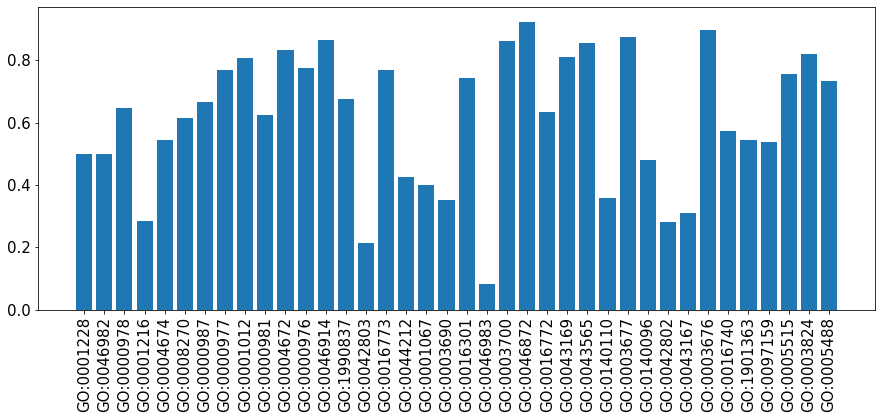

In [87]:
a=plt.figure(figsize=(15, 7))
terms = [i[0] for i in ordered_imbal]
probs = [recall_dic_old[i[0]] for i in ordered_imbal]
plt.bar(terms, probs)
plt.rcParams.update({'font.size': 15})
plt.xticks(rotation=90)
#plt.yscale('log')
plt.subplots_adjust(bottom=0.3, top=0.90)

plt.show()

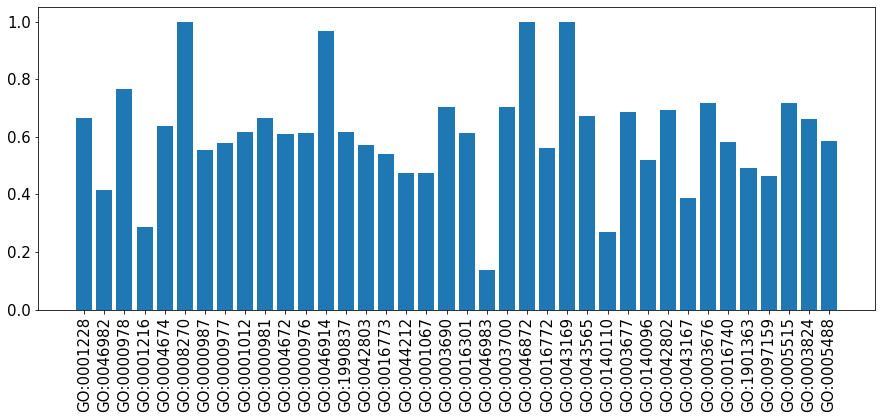

In [61]:
a=plt.figure(figsize=(15, 7))
terms = [i[0] for i in ordered_imbal]
probs = [recall_dic[i[0]] for i in ordered_imbal]
plt.bar(terms, probs)
plt.rcParams.update({'font.size': 15})
plt.xticks(rotation=90)
#plt.yscale('log')
plt.subplots_adjust(bottom=0.3, top=0.90)

plt.show()

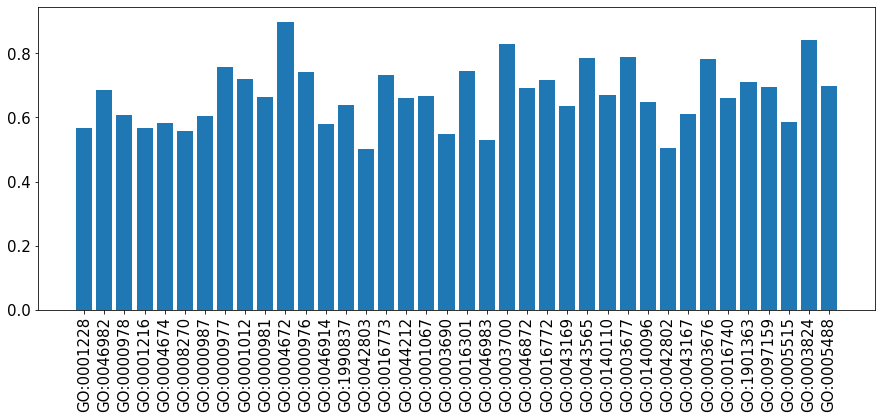

In [88]:
a=plt.figure(figsize=(15, 7))
terms = [i[0] for i in ordered_imbal]
probs = [bacc_dic_old[i[0]] for i in ordered_imbal]
plt.bar(terms, probs)
plt.rcParams.update({'font.size': 15})
plt.xticks(rotation=90)
#plt.yscale('log')
plt.subplots_adjust(bottom=0.3, top=0.90)

plt.show()

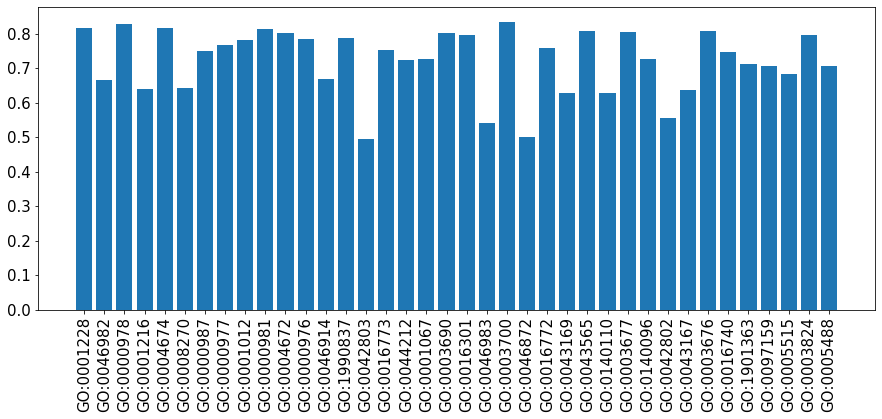

In [63]:
a=plt.figure(figsize=(15, 7))
terms = [i[0] for i in ordered_imbal]
probs = [bacc_dic[i[0]] for i in ordered_imbal]
plt.bar(terms, probs)
plt.rcParams.update({'font.size': 15})
plt.xticks(rotation=90)
#plt.yscale('log')
plt.subplots_adjust(bottom=0.3, top=0.90)

plt.show()

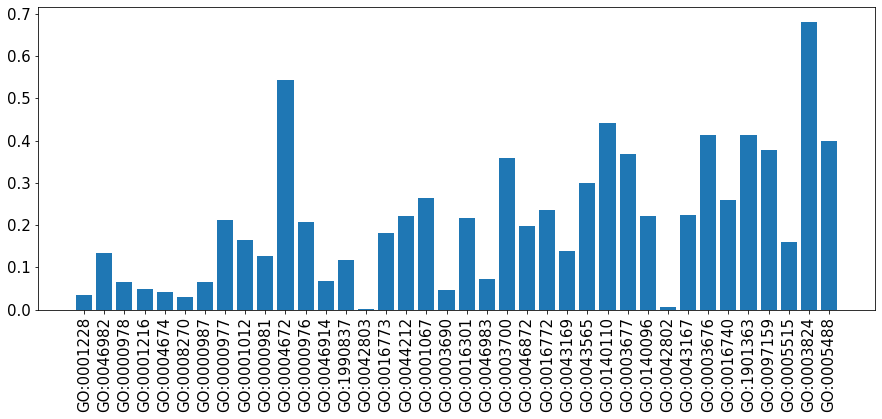

In [89]:
a=plt.figure(figsize=(15, 7))
terms = [i[0] for i in ordered_imbal]
probs = [matthew_dic_old[i[0]] for i in ordered_imbal]
plt.bar(terms, probs)
plt.rcParams.update({'font.size': 15})
plt.xticks(rotation=90)
#plt.yscale('log')
plt.subplots_adjust(bottom=0.3, top=0.90)

plt.show()

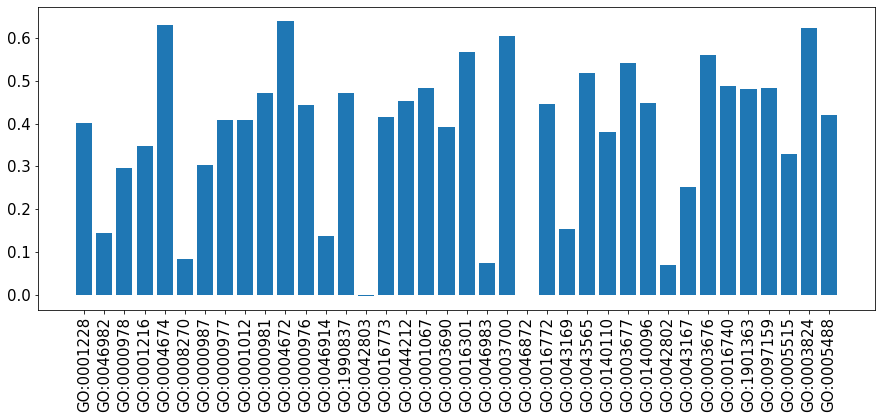

In [65]:
a=plt.figure(figsize=(15, 7))
terms = [i[0] for i in ordered_imbal]
probs = [matthew_dic[i[0]] for i in ordered_imbal]
plt.bar(terms, probs)
plt.rcParams.update({'font.size': 15})
plt.xticks(rotation=90)
#plt.yscale('log')
plt.subplots_adjust(bottom=0.3, top=0.90)

plt.show()

# test validation set results

In [14]:
probs = {}
name = list(names)

for i in range(38):
    """
    for all the different datasets
    dfCurrent = pd.read_pickle("DatasetsBalanced/Dataset_"+name[i]+".pkl")
    
    y_test = df["preds"].apply(lambda x: 1 if x[i]==1 else 0)            
    y_pred = df["preds_"+str(i)]
    
    truths = []
    for j in y_test.index:
        if j in dfCurrent.index:
            truths.append(True)
        else:
            truths.append(False)
            
    y_pred = y_pred[truths]
    y_test = y_test[truths]"""
    
    y_test = df["preds"].apply(lambda x: 1 if x[i]==1 else 0)  
    y_pred = df["preds_"+str(i)]


    #### TP

    #tp = df[truths][y_test==y_pred][y_pred == 1]["predProba_"+str(i)]
    tp = df[y_test==y_pred][y_pred == 1]["predProba_"+str(i)]

    #### TN

    #tn = df[truths][y_test==y_pred][y_pred == 0]["predProba_"+str(i)]
    tn = df[y_test==y_pred][y_pred == 0]["predProba_"+str(i)]

    #### FP

    #fp = df[truths][y_test!=y_pred][y_pred == 1]["predProba_"+str(i)]
    fp = df[y_test!=y_pred][y_pred == 1]["predProba_"+str(i)]

    #### FN

    #fn = df[truths][y_test!=y_pred][y_pred == 0]["predProba_"+str(i)]
    fn = df[y_test!=y_pred][y_pred == 0]["predProba_"+str(i)]

    
    probs[name[i]] = {"tp": np.average(tp), "tp_dev":np.std(tp), "tn": np.average(tn), "tn_dev":np.std(tn), "fp": np.average(fp), "fp_dev":np.std(fp), "fn": np.average(fn), "fn_dev":np.std(fn)}


/home/jonas/anaconda3/envs/pbl/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/jonas/anaconda3/envs/pbl/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/jonas/anaconda3/envs/pbl/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/jonas/anaconda3/envs/pbl/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [15]:
for i in probs:
    current = probs[i]
    if current["tp"] - current["tp_dev"] > current["fp"] + current["fp_dev"]:
        print(i+" is statistically significant")
    elif current["tp"] < current["fp"]:
        print(i+" terrible result")
    elif current["tp"] > current["fp"] + current["fp_dev"]:
        print(i+" at least a little")
    else:
        print(i+" Overlap of: "+str((current["tp"] - current["tp_dev"]) - (current["fp"] + current["fp_dev"])))

GO:0000976 at least a little
GO:0000977 Overlap of: -0.1246990500184979
GO:0000978 terrible result
GO:0000981 Overlap of: -0.11093920065748064
GO:0000987 Overlap of: -0.1586007038726467
GO:0001012 Overlap of: -0.1713316548399828
GO:0001067 Overlap of: -0.11167916520632715
GO:0001216 terrible result
GO:0001228 Overlap of: -0.15659399130695661
GO:0003676 Overlap of: -0.17867505020294971
GO:0003677 at least a little
GO:0003690 Overlap of: -0.1779815484928865
GO:0003700 at least a little
GO:0003824 Overlap of: -0.13153519995816065
GO:0004672 Overlap of: -0.2226969195236187
GO:0004674 at least a little
GO:0005488 Overlap of: -0.1354243679904218
GO:0005515 Overlap of: -0.16221173274294942
GO:0008270 terrible result
GO:0016301 at least a little
GO:0016740 Overlap of: -0.15632815248114384
GO:0016772 at least a little
GO:0016773 at least a little
GO:0042802 Overlap of: -0.1605597215101927
GO:0042803 terrible result
GO:0043167 Overlap of: -0.1874686510035195
GO:0043169 Overlap of: -0.20816983109